In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
import matplotlib.pyplot as plt

from thermonet.net import ThermoNetNew
from thermonet.dataset import ThermoDatasetNew
from utils.plot import PlotHandler

In [55]:
def epoch(net, dataloader, loss_func, optimizer, scheduler):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, d in enumerate(dataloader):
        inp = d[:, [0, -2, -1]]
        targets = d[:, 1].unsqueeze(-1)
        
        # Remove NaN values from targets (can occur because not every phase is defined in the same temperature range in the SGTE data)
        not_nas = torch.where(~torch.isnan(targets))
        targets = targets[not_nas]

        # Forward pass
        predictions = net(inp.float())
        predictions = predictions[not_nas]
        
        # Get the loss
        loss = loss_func(predictions, targets.float())
        
        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss
    scheduler.step()

    mean_epoch_loss = epoch_losses.mean(axis=0)
    #print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

def train(net, dataloader, optimizer, scheduler, loss_func, nr_epochs=500):
    losses = []
    
    best_loss = epoch(net, dataloader, loss_func, optimizer, scheduler)
    best_net = net
    
    ph = PlotHandler()

    for i in range(nr_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer, scheduler)
        losses.append(loss)
        
        if loss < best_loss:
            best_net = net
            
        if i % 10 == 0:
            print(i, ': ', loss)
            print('lr: ', scheduler.get_last_lr())
            last_losses = np.array(losses[-50:])
            last_losses_std, last_losses_mean = last_losses.std(), last_losses.mean()
            last_loss_diffs = np.diff(last_losses)
            print(np.mean(last_loss_diffs))
            print(last_losses_std/np.mean(last_loss_diffs), last_losses_std, last_losses_mean)
            print()
                
        if i % 250 == 0:
            ph.properties_temp_modified_new(best_net, ['Fe'], 'BCC_A2', start_temp=200, end_temp=2000)
            plt.plot(losses)
            
    return losses, net

In [23]:
# Hyperparameters
nr_epochs = 2500
lr = 0.01 # 0.000025
batch_size = 512
hidden_size = 128
hidden_layers = 8

In [56]:
# Network
net = ThermoNetNew(hidden_size_linear=hidden_size, hidden_layers=hidden_layers, out_features=1) 

# Optimizer
optimizer = RMSprop(net.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.995)

# Loss function
loss_func = MSELoss()

In [18]:
# Dataset
start_temp, end_temp = 200, 2000
step = 1
dataset = ThermoDatasetNew(['Fe'], start_temp=start_temp, end_temp=end_temp, step=step)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

0 :  2796584.8593103746
lr:  [0.009900250000000001]
nan
nan 0.0 2796584.8593103746



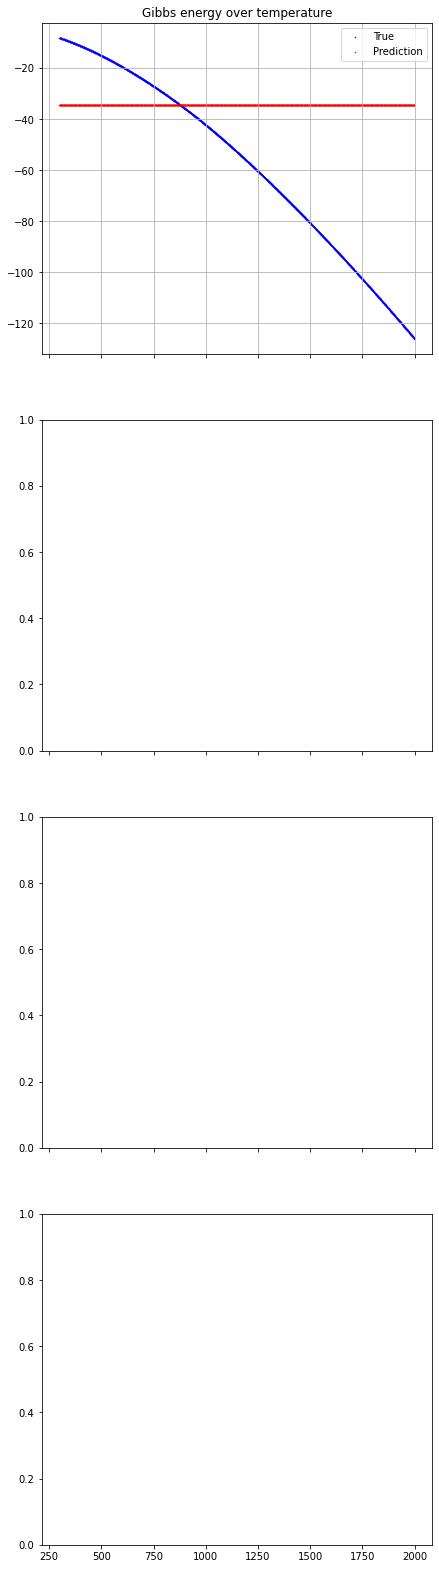

10 :  1287.427037856158
lr:  [0.009416228069143759]
-279529.74322725186
-2.8747214788845787 803570.156842472 255472.97790559984

20 :  1302.3858714384191
lr:  [0.008955869907338784]
-139764.1236719468
-4.25911916405915 595272.0575791218 134447.37528636944

30 :  1288.231653550092
lr:  [0.00851801859600347]
-93176.55425522751
-5.300369318930648 493870.1494180848 91547.17342195749

40 :  1286.3415958180146
lr:  [0.008101573778154729]
-69882.46294286392
-6.170144502848207 431184.8945724053 69532.67880752542

50 :  1290.4937528722426
lr:  [0.0077054888931188175]
-1.1828320927980591
-208.61292122191307 246.7540581936321 1343.4850420065484

60 :  1299.1283892463234
lr:  [0.007328768546436794]
0.0972054837559983
2365.901377727165 229.9785879409519 1329.5504239430147

70 :  163.8100155101103
lr:  [0.006970466008354944]
-23.169279723608074
-419.44608064525426 9718.263571440966 2620.6604153262865

80 :  173.6611489688649
lr:  [0.006629680834613699]
-22.791421805538526
-428.2156751749115 9759.644

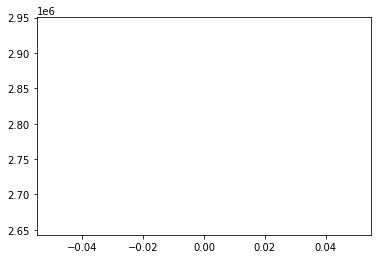

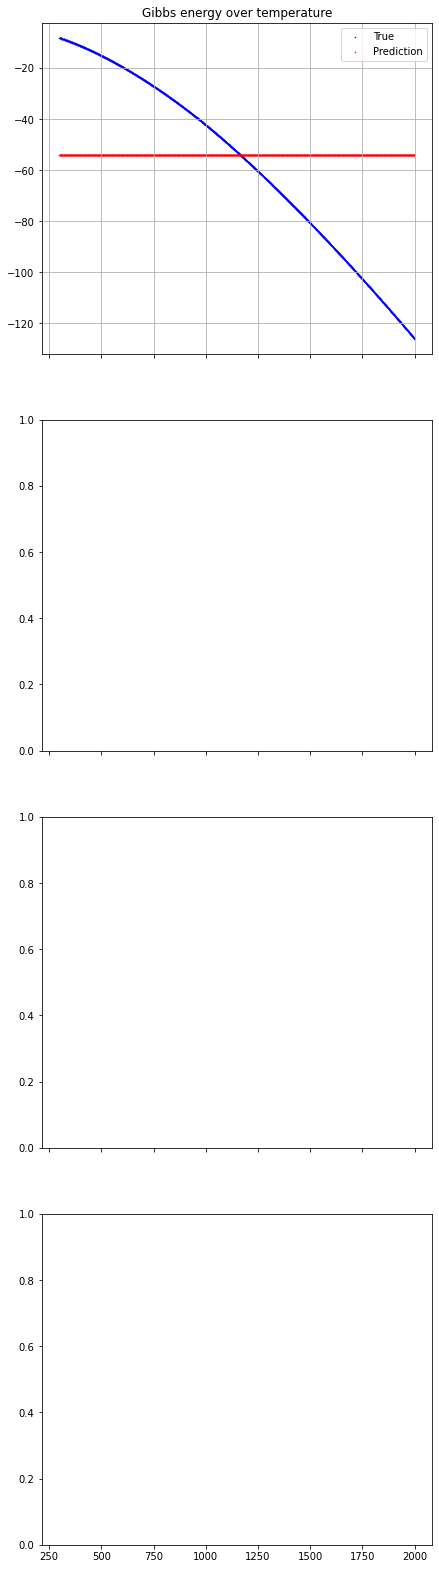

260 :  1286.8919462316176
lr:  [0.002689348941735692]
-0.019727471066535517
-128474.75327355272 2534.4819779843006 1648.2925679285386

270 :  149.34947294347427
lr:  [0.002557867022842219]
-23.294429490546403
-128.52313092575136 2993.873011254179 1808.9678220681585

280 :  103.99001446892234
lr:  [0.002432813237809558]
-24.090195691313692
-127.3217009960552 3067.204692745899 1581.455354237276

290 :  86.26244399126838
lr:  [0.002313873316011905]
-24.401797730811083
-72.4915247802325 1768.9235248853126 982.3218511738497

300 :  90.98452691470875
lr:  [0.0022007483514733506]
-24.33296866262372
-73.63230036832533 1791.6924574193574 745.3507974310481

310 :  86.93591039321002
lr:  [0.0020931540516921504]
-24.407992744216834
-73.06972072515136 1783.4852132814449 506.15591250924496

320 :  76.83770841710708
lr:  [0.00199082002318988]
-1.7823472589719482
-17.879399361667467 31.86729844433281 105.33057231454288

330 :  71.79224519168629
lr:  [0.0018934890919899976]
-0.996676750686847
-17.68593

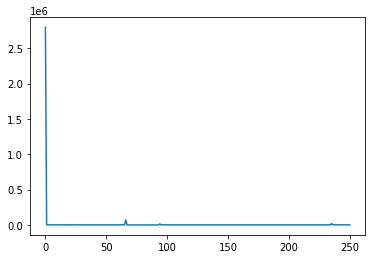

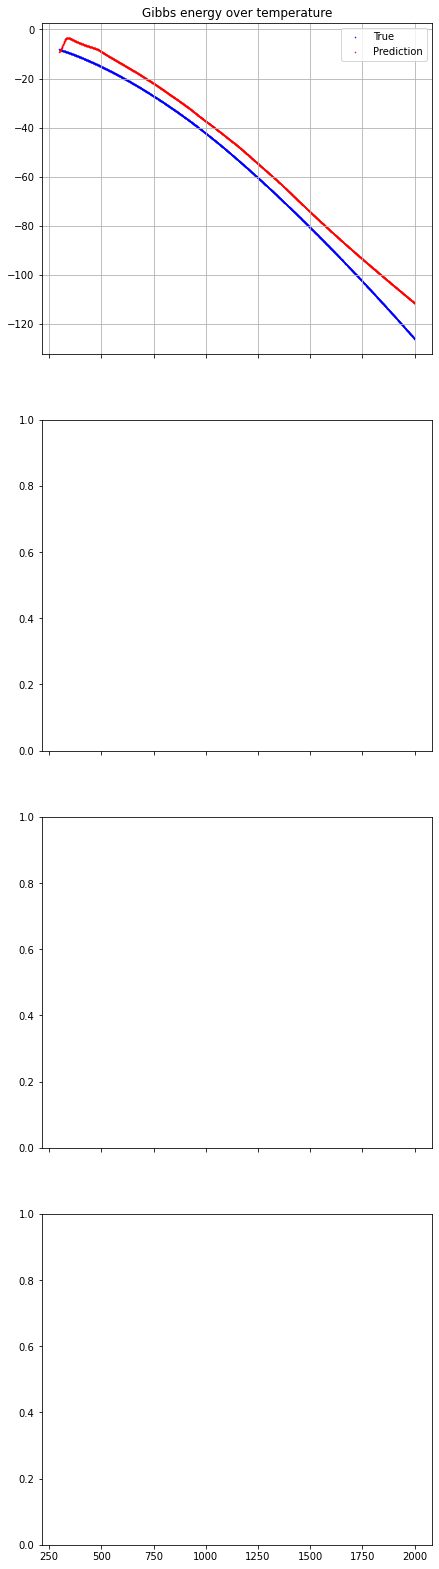

510 :  22.506907014285815
lr:  [0.0007680992513462519]
-0.3003392545830589
-14.469852658579676 4.3458647614045125 28.43581214119406

520 :  21.644147704629336
lr:  [0.0007305469791585952]
-0.1965960460264428
-19.00756099227039 3.7368113356868076 25.992776053372555

530 :  16.356275838964127
lr:  [0.0006948306326589069]
-0.33225197923712935
-11.747550517605363 3.9031469106625454 23.82808861732483

540 :  22.134395599365234
lr:  [0.0006608604536798278]
-0.11656264068127248
-32.44493760757739 3.7818676042783475 21.894948618832753

550 :  17.192272691165698
lr:  [0.0006285510723190903]
-0.20577340166107955
-18.45336754387312 3.7972122116049327 19.87877914989696

560 :  16.681427254396326
lr:  [0.0005978212923978105]
-0.10954576551842664
-33.13642253340924 3.629954772964357 18.174549944821525

570 :  14.135992050170898
lr:  [0.000568593887407698]
-0.11725030855542895
-31.552535052384773 3.699544470598102 16.48930353893953

580 :  11.671323664048138
lr:  [0.000540795406434376]
-0.14488091760

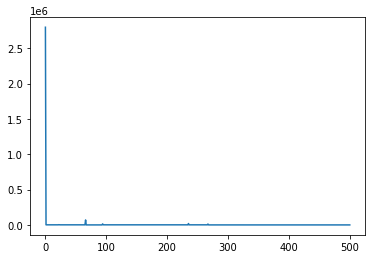

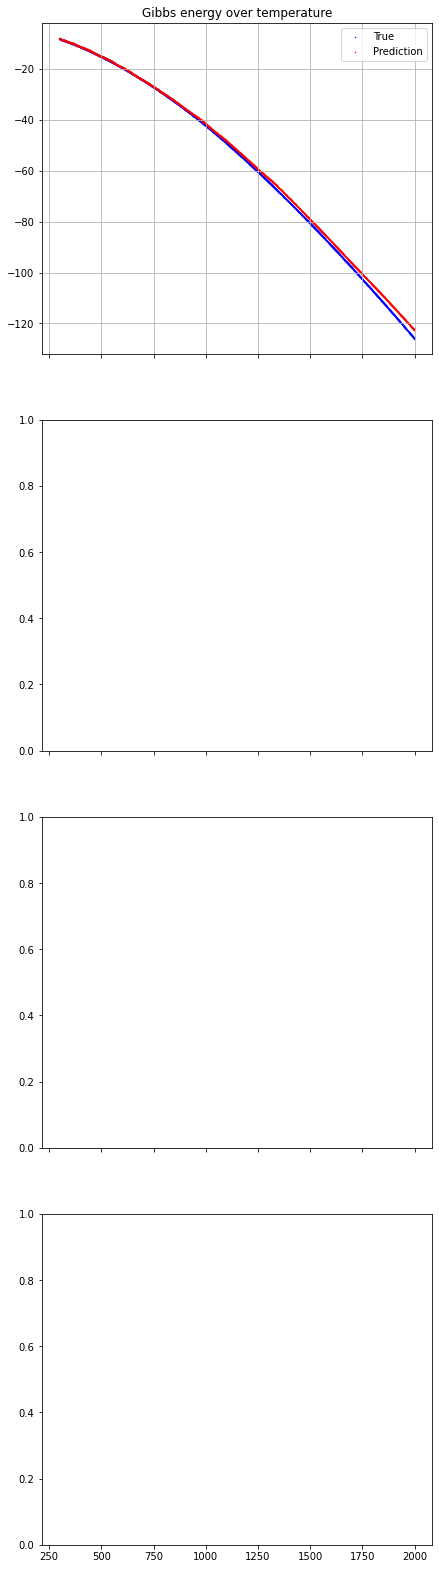

760 :  3.3691469185492573
lr:  [0.00021937519923982256]
-0.08789514099993483
-17.26117632060114 1.5171735265239736 3.564879564748091

770 :  3.0218690213035133
lr:  [0.0002086499743699423]
-0.07931207966546915
-16.608231700263005 1.3172333957138296 3.2522563666455886

780 :  3.0869304292342243
lr:  [0.00019844910434467576]
-0.0050337496353369
-236.60382686353722 1.1910044271936455 2.913412528493825

790 :  1.753807758583742
lr:  [0.0001887469535240801]
-0.05192622996750424
-20.648378147252192 1.0721924321302065 2.6163931075965654



In [ ]:
losses, best_net = train(net, dataloader, optimizer=optimizer, scheduler=scheduler, loss_func=loss_func, nr_epochs=nr_epochs)

In [ ]:
plt.plot(losses[1400:])

In [ ]:
#torch.save(net, 'Fe_C.pth')

In [ ]:
#net = torch.load('Fe_1.pth')

In [ ]:
ph = PlotHandler()

ph.properties_temp_modified_new(net, ['Fe'], 'BCC_A2', start_temp=200, end_temp=2000)